# B. M. Shahria Alam

# Data Importing

In [1]:
#Import The required Python libraries.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger,ProgbarLogger
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Create Test Dataset from orginal one

In [ ]:
import os
# Set your paths
source_dir = "/Users/bmshahriaalam/Desktop/Cucumber/Data set"
test_data_dir = "/Users/bmshahriaalam/Desktop/Cucumber/Test set"
test_split_ratio = 0.2  # Define the percentage of data to use for testing

# List your known class names
class_names = ['class1', 'class2', 'class3', 'class4']

# Create test data directory if it doesn't exist
os.makedirs(test_data_dir, exist_ok=True)

# Iterate over each specified class directory in the source directory
for class_name in class_names:
    class_source_path = os.path.join(source_dir, class_name)
    class_test_path = os.path.join(test_data_dir, class_name)
    
    # Check if the class directory exists
    if os.path.isdir(class_source_path):
        # Create class directory in the test set directory if it doesn't exist
        os.makedirs(class_test_path, exist_ok=True)
        
        # Get all file names in the class directory
        file_names = os.listdir(class_source_path)
        
        # Filter out hidden files
        file_names = [f for f in file_names if not f.startswith('.')]
        
        # Shuffle the list of file names
        random.shuffle(file_names)
        
        # Determine the number of files to move to the test set
        test_size = int(len(file_names) * test_split_ratio)
        
        # Move files to the test set directory
        for file_name in file_names[:test_size]:
            source_file = os.path.join(class_source_path, file_name)
            dest_file = os.path.join(class_test_path, file_name)
            shutil.move(source_file, dest_file)

print("Test set created successfully.")

In [ ]:
import shutil

# Function to manually remove .DS_Store directory if it exists
def remove_ds_store_directory(directory):
    ds_store_path = os.path.join(directory, '.DS_Store')
    if os.path.isdir(ds_store_path):
        shutil.rmtree(ds_store_path)
        print(f"Removed {ds_store_path}")

# Remove .DS_Store directory from the test data directory
remove_ds_store_directory(test_data_dir)


**Changable_Parameter**

In [3]:
#here image size is 256x256
IMAGE_SIZE = 224
#every time process 32 images (61x31)~1951
BATCH_SIZE = 32
#how many color have in these pictures
CHANNELS = 3
#80x25~1951
EPOCHS = 200
NUM_CLASSES = 4
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
patience=10
data_dir ="Path"

model_name="densenet201"  

In [ ]:
import os
import shutil
import random
import tensorflow as tf

# Define image parameters
img_height = IMAGE_SIZE
img_width = img_height
batch_size = BATCH_SIZE

# Define data augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,  # 10% of the data will be used for validation
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='training'  # specify that this generator will be used for training data
)


validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='validation'  # specify that this generator will be used for validation data
)




In [5]:
test_data_dir = 'test_data'  # Directory to store the test data


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Update for multi-class classification
)

Found 816 images belonging to 4 classes.


In [ ]:
images, labels = next(train_generator)

# Plot four random images from the batch
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Generate a random index
    random_index = np.random.randint(0, BATCH_SIZE)
    
    # Plot the image
    axes[i].imshow(images[random_index])
    
    # Get the corresponding label
    label = labels[random_index]
    
    # Set the title as the class name
    class_name = train_generator.class_indices
    axes[i].set_title(list(class_name.keys())[np.argmax(label)])

plt.show()

# Building model

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0,ResNet50,InceptionV3,NASNetMobile,EfficientNetV2L,DenseNet201

model= DenseNet201(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
                 )

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

**Fine Tuning**

In [8]:
for layer in model.layers[:220]:
   layer.trainable = False
for layer in model.layers[220:]:
   layer.trainable = True


In [9]:

def lw(bottom_model, num_classes):
    
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.6)(top_model) 
    top_model = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    # top_model = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(top_model)  # You can add regularization to more layers if needed
    # top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model) 
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [ ]:
from keras.models import Model
FC_Head = lw(model, NUM_CLASSES)
model = Model(inputs = model.input, outputs = FC_Head)
print(model.summary())

# Training

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
     if epoch < 5:
         return .0001
     else:
        return .0001

lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
if not os.path.exists("Results"):
    os.makedirs("Results")
if not os.path.exists("Model"):
    os.makedirs("Model") 
csv_logger_path = os.path.join("Results", f"{model_name}_results.csv")
model_checkpoint_path = os.path.join("Model", f"{model_name}_Model.hdf5")

# CheckPoints

In [13]:

csv_logger = CSVLogger(csv_logger_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
check = ModelCheckpoint(model_checkpoint_path, verbose=1, save_best_only=True)
progbar_logger = ProgbarLogger()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:


history = model.fit(train_generator,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    verbose = 1,
                    callbacks = [early_stopping,check,csv_logger],
                    initial_epoch=0)

In [15]:
model.save(f'{model_name}_.h5')

In [16]:
model = tf.keras.models.load_model(f'{model_name}_.h5')

# Result

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

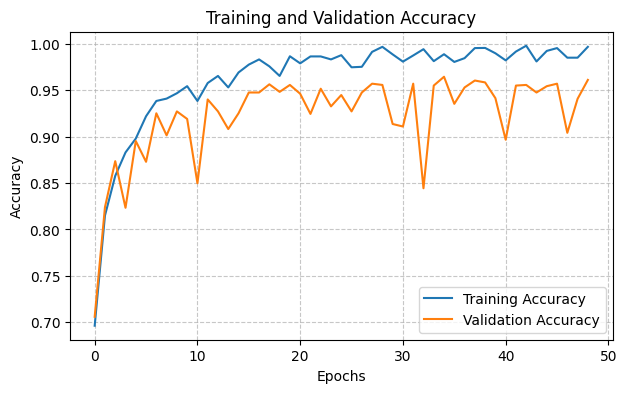

In [18]:

plt.figure(figsize=(7, 4))
plt.plot((epochs ), history.history['accuracy'], label='Training Accuracy')
plt.plot((epochs ), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

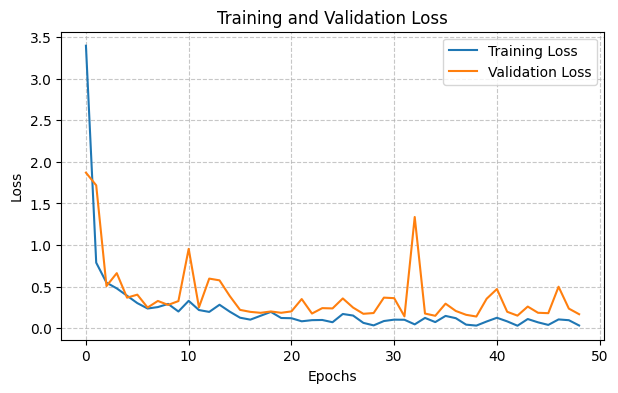

In [19]:
plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
        

In [20]:
score = model.evaluate(test_generator ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

41/41 [==============================] - 12s 149ms/step - loss: 0.2022 - accuracy: 0.9522
Test Loss: 0.20215579867362976
Test accuracy: 95.22058963775635


In [21]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true_all, y_pred_all, target_names=class_labels, zero_division=1)



1/1 [==============================] - 0s 79ms/step


In [22]:
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       204
           1       0.93      0.91      0.92       204
           2       0.95      0.93      0.94       204
           3       0.98      0.99      0.98       204

    accuracy                           0.95       816
   macro avg       0.95      0.95      0.95       816
weighted avg       0.95      0.95      0.95       816



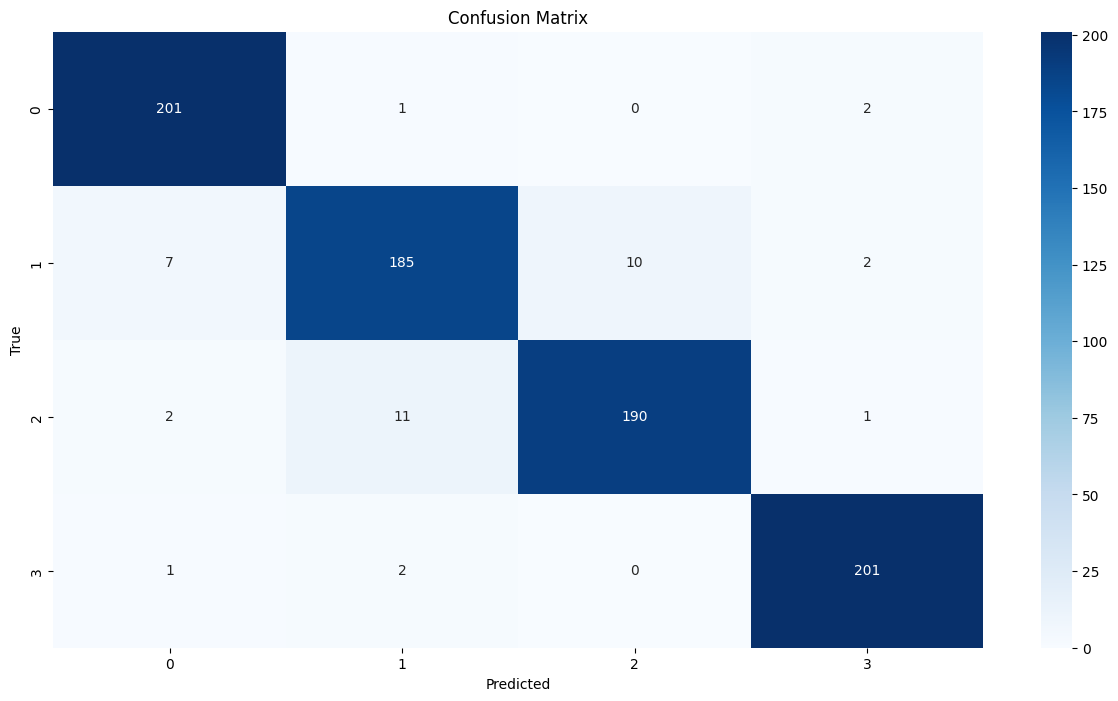

In [23]:
cm = confusion_matrix(y_true_all, y_pred_all)
import seaborn as sns
# Get class labels
class_labels = list(validation_generator.class_indices.keys())
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
# Plot confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

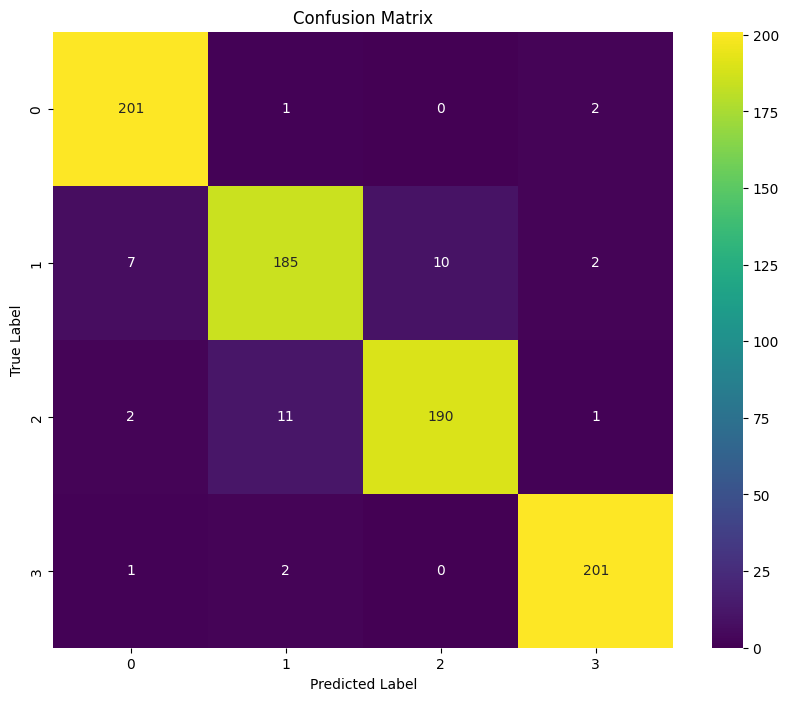

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix with a colorful palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
